# Sentiment Analysis: Analyzing Amazon reviews  

The task of this coursework is to perform a score and sentiment analysis in a set of reviews from different fine foods products of Amazon. The data consists of ratings of the comments, headers (review summary) and reviews. The dataset also contains different IDs of products and users initially but they are redundant: only score and text will be processed. Our aim is to find a relation between the vocabulary employed in the review and the degree of acceptance of the product.


The data for analysis is loaded in the environment. Only score, summary and text is preserved. The structure of the data is shown below.

In [1]:
import csv

# Path to the Reviews .csv and load to a RDD
path = 'hdfs://saltdean/data/reviews/Reviews.csv'
raw_data_RDD = sc.textFile(path).mapPartitions(lambda row: csv.reader(row))

# Store the headers, filter the first row and extract score, summary and text
headers = raw_data_RDD.first()
data_RDD = raw_data_RDD.filter(lambda row: row != headers)
reviews_RDD = data_RDD.map(lambda row: (row[6],row[8],row[9]))

# Print headers and one example
print("Headers of the dataset: ",headers,"\n")
print("Example of the initial dataset: ",data_RDD.take(2),"\n")
print("Example of the final dataset: ",reviews_RDD.take(1))


Headers of the dataset:  ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'] 

Example of the initial dataset:  [['1', 'B001E4KFG0', 'A3SGXH7AUHU8GW', 'delmartian', '1', '1', '5', '1303862400', 'Good Quality Dog Food', 'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'], ['2', 'B00813GRG4', 'A1D87F6ZCVE5NK', 'dll pa', '0', '0', '1', '1346976000', 'Not as Advertised', 'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".']] 

Example of the final dataset:  [('5', 'Good Quality Dog Food', 'I have bought several of the Vitality canned dog food products and have fou

## 1) Look inside the dataset

Once we have the dataset loaded, it is time to filter out possible missing values. In this particular case, the original dataset is cleaned, but if any pre-filtering operation is needed, it should be applied in the next cell. The final dataset contains roughly half-million reviews and scores. 

In order to make a deeper analysis in subsequent sections, we preserve the raw score and then, we generate a new sentiment column that labels reviews into positive (4-5 rating), negative (1-2 rating) and neutral(3 rating).

After the filtering, downsampling of the dataset have been performed. The classes are clearly imbalanced, the sum of scores 4 and 5 dominates the dataset in a ratio 4:1. As the dataset is big enough as to cut down its size without losing information (theoretically), downsample was the technique selected to solve the imbalancement problem.

In [2]:
# Display the initial number of items
print("The pre-wrangled size of the dataset is: ",reviews_RDD.count(),"\n")

# Remove rows which may contain score non-alphanumeric or empty text
possibleScores = ['1','2','3','4','5']
reviews_RDD_1 = reviews_RDD.filter(lambda row: row[0] in possibleScores)
reviews_RDD_2 = reviews_RDD_1.filter(lambda row: row[1] != '')
reviews_RDD_filtered = reviews_RDD_2.filter(lambda row: row[2] != '')

# Display the initial number of items
print("The post-wrangled size of the dataset is: ",reviews_RDD_filtered.count(),"\n")

# Now add the name of the score for possible visualizations 
scoreNames = {'1':"one",'2':"two",'3':"three",'4':"four",'5':"five"}
reviews_RDD_scores = reviews_RDD_filtered.map(lambda row: (scoreNames[row[0]],row[0],row[1],row[2]))

# Finally add the sentiment: score 1-2 bad, 3 neutral, 4-5 good
reviews_RDD_final = reviews_RDD_scores.map(lambda row: (row[0],row[1],row[2],row[3],"positive" if row[1] 
                                                        in ['4','5'] else "neutral" if row[1] == '3' else "negative"))
                                           
print("The shape of the dataset previously to the analysis is: ",reviews_RDD_final.take(1))


The pre-wrangled size of the dataset is:  568454 

The post-wrangled size of the dataset is:  568454 

The shape of the dataset previously to the analysis is:  [('five', '5', 'Good Quality Dog Food', 'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.', 'positive')]


In [3]:
import numpy as np

# Undersampling of the dataset (scores 4 and 5)
reviews_RDD_filtered = reviews_RDD_final.filter(lambda row: (row[4]!="positive") | (np.random.rand(1) > 0.8))

# Show the result
print("Result after filtering part of the positive labels: ",reviews_RDD_filtered.take(1))

# Show the dataset after downsampling
print("\nThe size of the dataset after downsampling is: ",reviews_RDD_filtered.count())


Result after filtering part of the positive labels:  [('five', '5', 'Good Quality Dog Food', 'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.', 'positive')]

The size of the dataset after downsampling is:  213435


## 2) Convert the dataset to a DataFrame

After the pre-processing, we will parse the dataset into a Spark DataFrame to carry out the analysis. DataFrames are column-based structures prepared to perform data analysis and create machine learning algorithms in an easier and more comprehensive way. Although the RDD can be used for analysis as well, DataFrames are more structured to apply models and statistical methods smoothly.



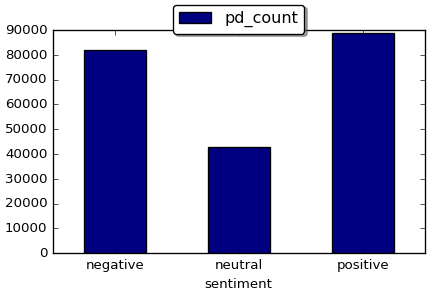

In [ ]:
from pyspark.sql.types import *
from pyspark.ml.linalg import Vector
from pyspark.sql import Row
from pyspark.sql import SQLContext
import pixiedust

sqlContext = SQLContext(sc)

# The schema is created for the DataFrame
names = ['scoreName','score','summary','text','sentiment']
fields = [StructField(field_name, StringType(), True) for field_name in names]
schema = StructType(fields)

# The dataframe is launched according to the schema created above
spark = SparkSession.builder.getOrCreate()
reviews_DF = spark.createDataFrame(reviews_RDD_filtered,schema)
reviews_DF.createOrReplaceTempView("reviews") 

# Show a bite of the DataFrame
reviews_DF.printSchema() # print the schema
SQL1 = "SELECT scoreName,score,summary,text,sentiment FROM reviews"
reviews_sql = spark.sql(SQL1)
reviews_sql.show(5)

# Visualize scores with pixidust
display(reviews_DF)

## 3) Text Processing Pipeline

In order to conduct different experiments with the dataframe, we create a text processing pipeline. Text data needs to be transformed into a set of numerical features for the analysis. In this project, we are using TF-IDF transformation, which accounts for a numerical value per word per document that weights the frequency and uniqueness of each word on each document. Then, hashing trick is used to reduce the dimensionality of the problem. Before transforming the words, they are tokenized and stopwords are removed to simplify the task.

Once we have a set of numerical features, the model fits the data and it is evaluated. To find the best combination of parameters, different scenarios are tested along the pipeline. Grid searching different combinations allow us to navigate the model to the optimal solution. 

Accuracy is used as the evaluation metric to measure how well the model is performing. To avoid overfitting, the accuracy is calculated in validation set. Cross-validation is the best vehicle to estimate the generalization performance, but the size of the dataset raises the computational cost of the task. Therefor in this project, we are using the TrainValidationSplit function in pyspark.ml.tuning package.

In [5]:
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import HashingTF,StopWordsRemover,IDF,Tokenizer
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

def setPipeline(model,inputCol):

    # Each message is broken into words with the predetermined Tokenizer 
    tokenizer = Tokenizer().setInputCol(inputCol).setOutputCol("words")
    
    # Stopwords are removed
    remover= StopWordsRemover().setInputCol("words").setOutputCol("filteredWords").setCaseSensitive(False)
    
    # Now the TF hashing trick is applied on the words of the text
    hashingTF = HashingTF().setNumFeatures(1000).setInputCol("filteredWords").setOutputCol("rawFeatures")
    
    # Now, idf is used to rescale the features
    idf = IDF().setInputCol("rawFeatures").setOutputCol("features").setMinDocFreq(0)
    
    # Pipeline is assemblied here
    grid = ParamGridBuilder().addGrid(hashingTF.numFeatures,[100,1000,10000]).addGrid(idf.minDocFreq,[0,10,100])
    pipeline = Pipeline(stages=[tokenizer,remover,hashingTF,idf,model]) 
    return (pipeline,grid)
    
    
def trainPipeline(pipeline,evaluator,data,grid): 
    
    # The validator is built up
    validator = TrainValidationSplit().setEstimator(pipeline).setEvaluator(evaluator)\
                                      .setEstimatorParamMaps(grid).setTrainRatio(0.8)
        
    # Finally train the pipeline and returns
    return validator.fit(data)

## 4) PCA analysis

The first step is to perform a PCA analysis on the dataset and check whether we are able to see any pattern on the data. Sentiment labels are used to see if any group or cluster appears and what kind of structures can the data show. In this case, dimensionality reduction allows us to bring high dimensional data into two dimensions just for the purpose of the visualization.

In [6]:
from pyspark.ml.feature import PCA

# Instantiate PCA model
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")

# Obtain the pipeline
pipeline,grid = setPipeline(pca,"text")

# And finally the analysis is performed
model = pipeline.fit(reviews_DF.select('text'))
transformed_pca = model.transform(reviews_DF.select('text'))

# Print some checkvalues
print("PCA input: \n")
reviews_DF.show(1)
print("PCA output: \n")
transformed_pca.show(1)

PCA input: 

+---------+-----+--------------------+--------------------+---------+
|scoreName|score|             summary|                text|sentiment|
+---------+-----+--------------------+--------------------+---------+
|     five|    5|Good Quality Dog ...|I have bought sev...| positive|
+---------+-----+--------------------+--------------------+---------+
only showing top 1 row

PCA output: 

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|               words|       filteredWords|         rawFeatures|            features|         pcaFeatures|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Product arrived l...|[product, arrived...|[product, arrived...|(1000,[121,127,17...|(1000,[121,127,17...|[-1.7068213371761...|
+--------------------+--------------------+--------------------+--------------------+--


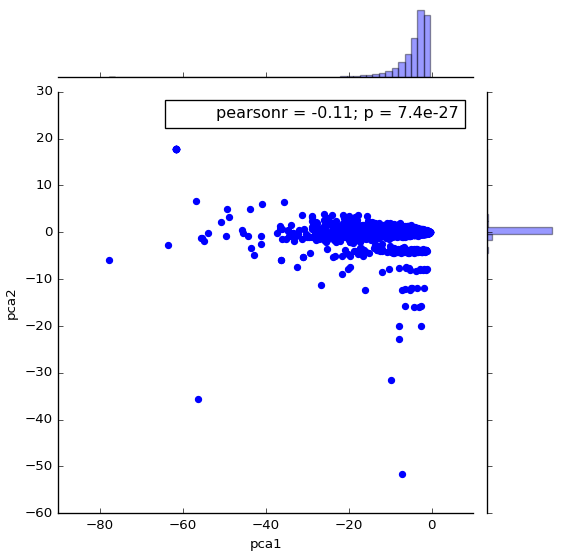

In [7]:
from pyspark.sql.functions import monotonically_increasing_id

# Try to plot the PCA projections backing to rdd and recreating the df
pca_rdd_raw = transformed_pca.select('pcaFeatures').rdd.map(tuple)
pca_rdd = pca_rdd_raw.map(lambda row: (float(row[0][0]),float(row[0][1])))
print("This is the RDD containing pca features: ",pca_rdd.take(1),"\n")

# Once we have the RDD, a new DF is created, again we create an schema
names_PCA = ["pca1","pca2"]
fields_PCA = [StructField(field_name, FloatType(), True) for field_name in names_PCA]
schema_PCA = StructType(fields_PCA)

# And with the schema, we create the dataset
pca_DF = spark.createDataFrame(pca_rdd,schema_PCA)

# Add indices to dataframes to join them in column sentiment 
reviews_DF = reviews_DF.withColumn("rowId1", monotonically_increasing_id())
pca_DF = pca_DF.withColumn("rowId2", monotonically_increasing_id())
pca_DF_plot = reviews_DF.join(pca_DF, reviews_DF.rowId1 == pca_DF.rowId2, 'inner').select(reviews_DF.sentiment, pca_DF.pca1, pca_DF.pca2)

# Print some flavours
pca_DF_plot.printSchema() 
pca_DF_plot.show(5)

# Visualize scores with pixidust
display(pca_DF_plot)


## 5) Create training and test set 

Training, validation and test set are split. We want to see our model generalizing in unseen cases and thus, data for testing phase must be stored. 

In [8]:
from pyspark.sql.functions import col, when

# Just store text, summary, sentiment and label
df = reviews_DF.drop('scoreName')
df = df.withColumn("label",when(col("sentiment")=='positive',2.0).when(col("sentiment")=='neutral',1.0).otherwise(0.0))
df = df.withColumn("score",df["score"].cast(DoubleType())-1)
final_df = df.drop('rowId1')
print("DataFrame for the analysis: ")
final_df.show(5)

# Data is split in training and test with a 80:20 ratio
train_set, test_set = final_df.randomSplit([0.8,0.2])

# Training and test set
print ("Training-set count:", train_set.count() )
print ("Test-set count:", test_set.count() )

DataFrame for the analysis: 
+-----+--------------------+--------------------+---------+-----+
|score|             summary|                text|sentiment|label|
+-----+--------------------+--------------------+---------+-----+
|  0.0|   Not as Advertised|Product arrived l...| negative|  0.0|
|  1.0|      Cough Medicine|If you are lookin...| negative|  0.0|
|  3.0|          Nice Taffy|I got a wild hair...| positive|  2.0|
|  4.0|    Healthy Dog Food|This is a very he...| positive|  2.0|
|  0.0|My Cats Are Not F...|My cats have been...| negative|  0.0|
+-----+--------------------+--------------------+---------+-----+
only showing top 5 rows

Training-set count: 171102
Test-set count: 42517


Now we prepare datasets downsampled to compare the effect of training models with dataset of different sizes. Initially we are going to train in roughly 2000 (1% of original) and 20000 (10% of original) examples. We are training in all possible dataset and testing the behaviour in the remaining reviews.

In [9]:
# Datasets of different sizes
train_small_1, test_small_1 = final_df.randomSplit([0.01,0.99])
train_small_2, test_small_2 = final_df.randomSplit([0.1,0.9])

# Print the number of items in each dataset
print ("Training-set count of small 1:", train_small_1.count() )
print ("Test-set count of small 1:", test_small_1.count() )
print ("Training-set count of small 2:", train_small_2.count() )
print ("Test-set count of small 2:", test_small_2.count() )

Training-set count of small 1: 2170
Test-set count of small 1: 210393
Training-set count of small 2: 21139
Test-set count of small 2: 192288


## 6) Classification by score

The first set of experiments is create a prediction model to predict the score given by user to a certain product. Initially we expect to see some sort of relation between score and language style, and the model would not perform quite well, as everyone does not rate the same way or are prone to give extreme scores.

The analysis will be performed with three different classification algorithms: Naive Bayes, Logistic Regression and Random Forest. Accuracy will be used as the main metric, but further parameters will be investigated in the final models. Performance needs to be deeply evaluated and the following function will be employed to do so.

Notice that score is labeled as 1: 0.0, 2: 1.0, 3: 2.0, 4: 3.0 and 5: 4.0. This is due to the fact that data needs to be tailored to the functions used.

In [10]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def evaluatePerformance(model,data,outputCol,possibleLabels):

    # Predictions on test set
    test_predictions = model.transform(data)

    # Show some information of the created dataset
    test_predictions.select("text",outputCol,"prediction").show(5)

    # Parse data into RDD to metrics analysis
    test_predictions_rdd = test_predictions.select(outputCol,"prediction").rdd.map(lambda row: (row[0],row[1]))
    print(test_predictions_rdd.take(4))

    # Metrics to analyse the data
    metrics = MulticlassMetrics(test_predictions_rdd)

    # Summary stats
    for label in possibleLabels:
        print("\nRecall of label ",label," is: ",metrics.recall(label))
        print("Precision of label ",label," is: ",metrics.precision(label))

    # Confusion Matrix
    confusionMatrix = metrics.confusionMatrix().toArray()
    print("\nConfusion Matrix: \n")
    print(confusionMatrix)

**First experiment:** Classification of score using Random Forest on text column

In [11]:
# Instantiate Random Forest and train the pipeline
rf = RandomForestClassifier(labelCol="score")
evaluator = MulticlassClassificationEvaluator().setMetricName("accuracy").setLabelCol("score")

# Set pipeline and grid of general parameters. Add the parameters of the model
pipeline, paramGrid = setPipeline(rf,"text")
paramGrid = paramGrid.addGrid(rf.numTrees,[10, 100])\
    .addGrid(rf.maxDepth,[1, 10])\
    .build()
    
# Finally train the pipeline
%time model_rf = trainPipeline(pipeline,evaluator,train_set,paramGrid)
print("Accuracy of the best fitted model on training set =",evaluator.evaluate(model_rf.transform(train_set)))
print("Accuracy of the best fitted model on test set =",evaluator.evaluate(model_rf.transform(test_set)))
print("\n")

# Advanced test
possibleLabels = [0.0,1.0,2.0,3.0,4.0]
evaluatePerformance(model_rf,test_set,"score",possibleLabels)

CPU times: user 8.54 s, sys: 2.39 s, total: 10.9 s
Wall time: 58min 41s
Accuracy of the best fitted model on training set = 0.4454605482285708
Accuracy of the best fitted model on test set = 0.42342786104660707


+--------------------+-----+----------+
|                text|score|prediction|
+--------------------+-----+----------+
|We bought a carto...|  0.0|       4.0|
|We bought a carto...|  0.0|       4.0|
|The new flavor is...|  0.0|       4.0|
|These noodles wer...|  0.0|       0.0|
|Sunday breakfast ...|  0.0|       2.0|
+--------------------+-----+----------+
only showing top 5 rows

[(0.0, 4.0), (0.0, 4.0), (0.0, 4.0), (0.0, 0.0)]

Recall of label  0.0  is:  0.4555661729574773
Precision of label  0.0  is:  0.37177112779023297

Recall of label  1.0  is:  0.9954128440366973
Precision of label  1.0  is:  0.03684836135167261

Recall of label  2.0  is:  0.5466531440162272
Precision of label  2.0  is:  0.1250725142127857

Recall of label  3.0  is:  1.1666666666666667
Precision of lab

**Second experiment:** Classification of score using Naive Bayes on text column

In [12]:
# Instantiate Naive Bayes and train the pipeline
nb = NaiveBayes(labelCol="score")
evaluator = MulticlassClassificationEvaluator().setMetricName("accuracy").setLabelCol("score")

# Set pipeline and grid of general parameters. Add the parameters of the model
pipeline, paramGrid = setPipeline(nb,"text")
paramGrid = paramGrid.addGrid(nb.smoothing,[0.0,0.5,1.0])\
    .build()

# Finally train the pipeline
%time model_nb = trainPipeline(pipeline,evaluator,train_set,paramGrid)
print("Accuracy of the best fitted model on training set =",evaluator.evaluate(model_nb.transform(train_set)))
print("Accuracy of the best fitted model on test set =",evaluator.evaluate(model_nb.transform(test_set)))
print("\n")

# Advanced test
possibleLabels = [0.0,1.0,2.0,3.0,4.0]
evaluatePerformance(model_nb,test_set,"score",possibleLabels)

CPU times: user 4.23 s, sys: 872 ms, total: 5.1 s
Wall time: 7min 56s
Accuracy of the best fitted model on training set = 0.5694115583618347
Accuracy of the best fitted model on test set = 0.541908400547144


+--------------------+-----+----------+
|                text|score|prediction|
+--------------------+-----+----------+
|We bought a carto...|  0.0|       0.0|
|We bought a carto...|  0.0|       0.0|
|The new flavor is...|  0.0|       0.0|
|These noodles wer...|  0.0|       3.0|
|Sunday breakfast ...|  0.0|       2.0|
+--------------------+-----+----------+
only showing top 5 rows

[(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 3.0)]

Recall of label  0.0  is:  0.626675041876047
Precision of label  0.0  is:  0.5834876693634857

Recall of label  1.0  is:  0.34743969530258145
Precision of label  1.0  is:  0.41823739174732555

Recall of label  2.0  is:  0.47427588943261473
Precision of label  2.0  is:  0.41605754727926675

Recall of label  3.0  is:  0.22540900828115532
Precision of label

**Third experiment:** Classification of score using Logistic Regression on text column

In [14]:
# Instantiate Logistic Regression and train the pipeline
lr = LogisticRegression(labelCol="score")
evaluator = MulticlassClassificationEvaluator().setMetricName("accuracy").setLabelCol("score")

# Set pipeline and grid of general parameters. Add the parameters of the model
pipeline, paramGrid = setPipeline(lr,"text")
paramGrid = paramGrid.addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0])\
    .build()

# Finally train the pipeline
%time model_lr = trainPipeline(pipeline,evaluator,train_set,paramGrid)
print("Accuracy of the best fitted model on training set =",evaluator.evaluate(model_lr.transform(train_set)))
print("Accuracy of the best fitted model on test set =",evaluator.evaluate(model_lr.transform(test_set)))
print("\n")

# Advanced test
possibleLabels = [0.0,1.0,2.0,3.0,4.0]
evaluatePerformance(model_lr,test_set,"score",possibleLabels)

CPU times: user 6.03 s, sys: 1.85 s, total: 7.88 s
Wall time: 14min 6s
Accuracy of the best fitted model on training set = 0.6874846539689221
Accuracy of the best fitted model on test set = 0.6256734818718679


+--------------------+-----+----------+
|                text|score|prediction|
+--------------------+-----+----------+
|We bought a carto...|  0.0|       0.0|
|We bought a carto...|  0.0|       0.0|
|The new flavor is...|  0.0|       0.0|
|These noodles wer...|  0.0|       2.0|
|Sunday breakfast ...|  0.0|       0.0|
+--------------------+-----+----------+
only showing top 5 rows

[(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 2.0)]

Recall of label  0.0  is:  0.669975412075403
Precision of label  0.0  is:  0.7171264255775417

Recall of label  1.0  is:  0.46549586776859503
Precision of label  1.0  is:  0.3825776872134488

Recall of label  2.0  is:  0.5434365250779938
Precision of label  2.0  is:  0.5254669915303399

Recall of label  3.0  is:  0.33608147429679924
Precision of label 

## 7) Classification by sentiment 

As seen from the above experiment, performances of the best models are show a certain degree of correlation between the score and review, but not too strong. As it was mentioned previously, guessing the proper score may be tricky. Thus, information is aggregated into sentiments to provide a way of summarizing what is a clearly positive review ( 4 or 5) and what is a negative review (1 and 2) as well as a neutral category (3).

Again, performance is evaluated thoroughly and the same three classification algorithms are used. Notice that 'positive' is labelled as 2.0, 'neutral' as 1.0 and 'negative' as 0.0, again for the purpose of the requirements of the techniques used.

**Fourth experiment:** Classification of sentiment using Random Forest on text column

In [15]:
# Instantiate Random Forest and train the pipeline
rf = RandomForestClassifier(labelCol="label")
evaluator = MulticlassClassificationEvaluator().setMetricName("accuracy").setLabelCol("label")

# Set pipeline and grid of general parameters. Add the parameters of the model
pipeline, paramGrid = setPipeline(rf,"text")
paramGrid = paramGrid.addGrid(rf.numTrees,[10, 100])\
    .addGrid(rf.maxDepth,[1, 10])\
    .build()
    
# Finally train the pipeline
%time model_rf_sentiment = trainPipeline(pipeline,evaluator,train_set,paramGrid)
print("Accuracy of the best fitted model on training set =",evaluator.evaluate(model_rf_sentiment.transform(train_set)))
print("Accuracy of the best fitted model on test set =",evaluator.evaluate(model_rf_sentiment.transform(test_set)))
print("\n")

# Advanced test
possibleLabels = [0.0,1.0,2.0]
evaluatePerformance(model_rf_sentiment,test_set,"label",possibleLabels)

CPU times: user 14.4 s, sys: 5.5 s, total: 19.9 s
Wall time: 1h 4min 52s
Accuracy of the best fitted model on training set = 0.6099812017966632
Accuracy of the best fitted model on test set = 0.5990663413718682


+--------------------+-----+----------+
|                text|label|prediction|
+--------------------+-----+----------+
|We bought a carto...|  0.0|       0.0|
|We bought a carto...|  0.0|       0.0|
|The new flavor is...|  0.0|       0.0|
|These noodles wer...|  0.0|       2.0|
|Sunday breakfast ...|  0.0|       0.0|
+--------------------+-----+----------+
only showing top 5 rows

[(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 2.0)]

Recall of label  0.0  is:  0.6970960766141489
Precision of label  0.0  is:  0.5589546693088927

Recall of label  1.0  is:  1.0
Precision of label  1.0  is:  0.005453068801485091

Recall of label  2.0  is:  0.5592376954843951
Precision of label  2.0  is:  0.927312528064661

Confusion Matrix: 

[[ 9026.  2630.  1302.]
 [    0.    47.     0.]
 [ 7122.  

**Fifth experiment:** Classification of sentiment using Naive Bayes on text column

In [16]:
# Instantiate Naive Bayes and train the pipeline
nb = NaiveBayes(labelCol="label")
evaluator = MulticlassClassificationEvaluator().setMetricName("accuracy").setLabelCol("label")

# Set pipeline and grid of general parameters. Add the parameters of the model
pipeline, paramGrid = setPipeline(nb,"text")
paramGrid = paramGrid.addGrid(nb.smoothing,[0.0,0.5,1.0])\
    .build()

# Finally train the pipeline
%time model_nb_sentiment = trainPipeline(pipeline,evaluator,train_set,paramGrid)
print("Accuracy of the best fitted model on training set =",evaluator.evaluate(model_nb_sentiment.transform(train_set)))
print("Accuracy of the best fitted model on test set =",evaluator.evaluate(model_nb_sentiment.transform(test_set)))
print("\n")

# Advanced test
possibleLabels = [0.0,1.0,2.0]
evaluatePerformance(model_nb_sentiment,test_set,"label",possibleLabels)

CPU times: user 5.41 s, sys: 1.41 s, total: 6.82 s
Wall time: 8min 44s
Accuracy of the best fitted model on training set = 0.6941867402927103
Accuracy of the best fitted model on test set = 0.6819575471698113


+--------------------+-----+----------+
|                text|label|prediction|
+--------------------+-----+----------+
|We bought a carto...|  0.0|       0.0|
|We bought a carto...|  0.0|       0.0|
|The new flavor is...|  0.0|       0.0|
|These noodles wer...|  0.0|       2.0|
|Sunday breakfast ...|  0.0|       1.0|
+--------------------+-----+----------+
only showing top 5 rows

[(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 2.0)]

Recall of label  0.0  is:  0.7311040486389387
Precision of label  0.0  is:  0.6553133514986376

Recall of label  1.0  is:  0.4396887159533074
Precision of label  1.0  is:  0.5637544958811928

Recall of label  2.0  is:  0.7850856606430415
Precision of label  2.0  is:  0.7552633064288536

Confusion Matrix: 

[[10582.  2078.  1816.]
 [ 3707.  4859.  2574.

**Sixth experiment:** Classification of sentiment using Logistic Regression on text column

In [17]:
# Instantiate Logistic Regression and train the pipeline
lr = LogisticRegression(labelCol="label")
evaluator = MulticlassClassificationEvaluator().setMetricName("accuracy").setLabelCol("label")

# Set pipeline and grid of general parameters. Add the parameters of the model
pipeline, paramGrid = setPipeline(lr,"text")
paramGrid = paramGrid.addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0])\
    .build()

# Finally train the pipeline
%time model_lr_sentiment = trainPipeline(pipeline,evaluator,train_set,paramGrid)
print("Accuracy of the best fitted model on training set =",evaluator.evaluate(model_lr_sentiment.transform(train_set)))
print("Accuracy of the best fitted model on test set =",evaluator.evaluate(model_lr_sentiment.transform(test_set)))
print("\n")

# Advanced test
possibleLabels = [0.0,1.0,2.0]
evaluatePerformance(model_lr_sentiment,test_set,"label",possibleLabels)

CPU times: user 8.3 s, sys: 2.35 s, total: 10.7 s
Wall time: 13min 23s
Accuracy of the best fitted model on training set = 0.7738628335892481
Accuracy of the best fitted model on test set = 0.7403932292894526


+--------------------+-----+----------+
|                text|label|prediction|
+--------------------+-----+----------+
|We bought a carto...|  0.0|       0.0|
|We bought a carto...|  0.0|       0.0|
|The new flavor is...|  0.0|       0.0|
|These noodles wer...|  0.0|       2.0|
|Sunday breakfast ...|  0.0|       1.0|
+--------------------+-----+----------+
only showing top 5 rows

[(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 2.0)]

Recall of label  0.0  is:  0.7472533928676341
Precision of label  0.0  is:  0.7876517215754273

Recall of label  1.0  is:  0.5815549917922698
Precision of label  1.0  is:  0.45214061956143403

Recall of label  2.0  is:  0.7830253613596654
Precision of label  2.0  is:  0.8312629981451296

Confusion Matrix: 

[[12719.  2561.  1739.]
 [ 1569.  3897.  1261

## 8) Comparison of models downsampled

The best approach (Logistic Regression) is compared with the models trained with less data to show how the models perform when feeded with less data. We want to see how the behaviour of the models change with different amount of data used in training.

Ideally, if a smaller amount of data is representative enough, adding more data will not improve the global performance of the model. However, in practice the latter case seems to be the correct one. We will see if that applies to our dataset. The analysis is performed in the best model obtained up to now.

**Seventh experiment:** Classification of sentiment using Logistic Regression on text column (downsampled dataset 1)

In [20]:
# Instantiate Logistic Regressor and train the pipeline
lr = LogisticRegression(labelCol="label")
evaluator = MulticlassClassificationEvaluator().setMetricName("accuracy").setLabelCol("label")

# Set pipeline and grid of general parameters. Add the parameters of the model
pipeline, paramGrid = setPipeline(nb,"text")
paramGrid = paramGrid.addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0])\
    .build()

# Finally train the pipeline
%time model_lr_small1 = trainPipeline(pipeline,evaluator,train_small_1,paramGrid)
print("Accuracy of the best fitted model on training set =",evaluator.evaluate(model_lr_small1.transform(train_small_1)))
print("Accuracy of the best fitted model on test set =",evaluator.evaluate(model_lr_small1.transform(test_small_1)))
print("\n")

# Advanced test
possibleLabels = [0.0,1.0,2.0]
evaluatePerformance(model_lr_small1,test_small_1,"label",possibleLabels)

CPU times: user 3.38 s, sys: 820 ms, total: 4.2 s
Wall time: 54.3 s
Accuracy of the best fitted model on training set = 0.7410468319559229
Accuracy of the best fitted model on test set = 0.5906348831720557


+--------------------+-----+----------+
|                text|label|prediction|
+--------------------+-----+----------+
|White peaches are...|  0.0|       0.0|
|I purchased this ...|  0.0|       0.0|
|I hate to rag on ...|  0.0|       0.0|
|No flavor at all....|  0.0|       0.0|
|Here is the MIO P...|  0.0|       0.0|
+--------------------+-----+----------+
only showing top 5 rows

[(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0)]

Recall of label  0.0  is:  0.607282335353629
Precision of label  0.0  is:  0.6453253534308655

Recall of label  1.0  is:  0.3449001702522829
Precision of label  1.0  is:  0.263878363016294

Recall of label  2.0  is:  0.662249661195603
Precision of label  2.0  is:  0.6988558975755925

Confusion Matrix: 

[[52403. 16479. 17480.]
 [11866. 11142.  9390.]
 [16

**Eigth experiment:** Classification of sentiment using Logistic Regression on text column (downsampled dataset 2)

In [21]:
# Instantiate Logistic Regression and train the pipeline
lr = LogisticRegression(labelCol="label")
evaluator = MulticlassClassificationEvaluator().setMetricName("accuracy").setLabelCol("label")

# Set pipeline and grid of general parameters. Add the parameters of the model
pipeline, paramGrid = setPipeline(nb,"text")
paramGrid = paramGrid.addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0])\
    .build()

# Finally train the pipeline
%time model_lr_small2 = trainPipeline(pipeline,evaluator,train_small_2,paramGrid)
print("Accuracy of the best fitted model on training set =",evaluator.evaluate(model_lr_small2.transform(train_small_2)))
print("Accuracy of the best fitted model on test set =",evaluator.evaluate(model_lr_small2.transform(test_small_2)))
print("\n")

# Advanced test
possibleLabels = [0.0,1.0,2.0]
evaluatePerformance(model_lr_small2,test_small_2,"label",possibleLabels)

CPU times: user 4.12 s, sys: 996 ms, total: 5.11 s
Wall time: 1min 50s
Accuracy of the best fitted model on training set = 0.6762430417963959
Accuracy of the best fitted model on test set = 0.6468542770154732


+--------------------+-----+----------+
|                text|label|prediction|
+--------------------+-----+----------+
|White peaches are...|  0.0|       0.0|
|I purchased this ...|  0.0|       0.0|
|I hate to rag on ...|  0.0|       0.0|
|No flavor at all....|  0.0|       1.0|
|Here is the MIO P...|  0.0|       0.0|
+--------------------+-----+----------+
only showing top 5 rows

[(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 1.0)]

Recall of label  0.0  is:  0.6898362681495211
Precision of label  0.0  is:  0.6639635621511306

Recall of label  1.0  is:  0.40606762389995366
Precision of label  1.0  is:  0.4558548252911814

Recall of label  2.0  is:  0.7439396843652163
Precision of label  2.0  is:  0.7289882294014526

Confusion Matrix: 

[[49126. 11613. 10305.]
 [14430. 17534. 11238

## 9) Effect of classification on summary

The last experiment consists of analyzing the summary instead of the whole text. Summary is supposed to condense the information about user's degree of acceptability of the product. Thus, if a model fitted to the summary works well, the computational complexity of the model will go down, as long as the system is processing a considerable less amount of words. Again, the technique is applied over the best performing model: Logistic Regression on sentiment analysis.

**Ninth experiment:** Classification of sentiment using Logistic Regression on summary column

In [22]:
# Instantiate Logistic Regression and train the pipeline
lr = LogisticRegression(labelCol="label")
evaluator = MulticlassClassificationEvaluator().setMetricName("accuracy").setLabelCol("label")

# Set pipeline and grid of general parameters. Add the parameters of the model
pipeline, paramGrid = setPipeline(nb,"summary")
paramGrid = paramGrid.addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0])\
    .build()

# Finally train the pipeline
%time model_lr_summary = trainPipeline(pipeline,evaluator,train_set,paramGrid)
print("Accuracy of the best fitted model on training set =",evaluator.evaluate(model_lr_summary.transform(train_set)))
print("Accuracy of the best fitted model on test set =",evaluator.evaluate(model_lr_summary.transform(test_set)))
print("\n")

# Advanced test
possibleLabels = [0.0,1.0,2.0]
evaluatePerformance(model_lr_summary,test_set,"label",possibleLabels)

CPU times: user 4.04 s, sys: 948 ms, total: 4.98 s
Wall time: 1min 44s
Accuracy of the best fitted model on training set = 0.6859303711619877
Accuracy of the best fitted model on test set = 0.6588888366185257


+--------------------+-----+----------+
|                text|label|prediction|
+--------------------+-----+----------+
|We bought a carto...|  0.0|       0.0|
|We bought a carto...|  0.0|       0.0|
|The new flavor is...|  0.0|       0.0|
|These noodles wer...|  0.0|       0.0|
|Sunday breakfast ...|  0.0|       0.0|
+--------------------+-----+----------+
only showing top 5 rows

[(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0)]

Recall of label  0.0  is:  0.7133891213389121
Precision of label  0.0  is:  0.6335149863760218

Recall of label  1.0  is:  0.44018638265500193
Precision of label  1.0  is:  0.537069265576053

Recall of label  2.0  is:  0.7386574987318942
Precision of label  2.0  is:  0.736168061562658

Confusion Matrix: 

[[10230.  2000.  2063.]
 [ 3244.  4629.  2606.]

## 10) Conclusions

1) First of all, the comparison between the three models in score classificaton is interesting. Although Random Forest is the more complex model and it should be able of capturing more complex patterns, it does a really poor job in comparison with more simple and linear approaches such as Logistic Regression and Naive Bayes (42% vs 62% and 54% respectively in test set). However, not only accuracy is the only aspect to check. Training time is significantly longer with Random Forest (58 min vs 7 min and 14 min respectively). Thus, the size effect starts to become significant: when data increases, simple models would still work surprisingly good, sometimes even outperform more complex models. In the case of this project, Logistic Regression is the best performing model.

2) Another interesting point of the score classification can be seen in the confusion matrix. Precision and recall is higher in both extreme scores: 1 and 5. One possible explanation is the fact that extremely good or bad reviews (and vocabulary) is translated into the best or worse possible score. Central scores would be related with more vague and abstract use of the language. This is one of the reasons why it was decided to summarize scores into sentiments. Negative and positive vocabulary will be more distinguishable.

3) The sentiment analysis performs better than predicting rating in terms of accuracies of the three models. The best performing model (Logistic Regression) scores a decent degree of accuracy: 74% in test set. This means 12 more points compared with the score prediction. Again, prediction of positive and negative values is better than the neutral ones. Indeed, precision of positive and negative labels is nearly 80%.

4) Regarding the downsampled experiments some insights can be obtained. Downsampled dataset are roughly 1% and 10% of the initial dataset. It can be seen the instability of the model trained in the 1% downsampled dataset: training accuracy is almost the same as the total model but the generalization to test examples fails dramatically ( 54% accuracy). This dataset is clearly too small as to map decently the reviews space. If we use the 10% downsampled dataset it can be seen more stable results: training are test accuracies are similar. However, these accuracies are almost 10 points below the accuracy obtained by the model in the full dataset (64% vs 74% in test set). Theoretically, if the dataset is representative, more data is not needed. But from this experiment it shows that in practice more data can lead to better results.

5) It is interesting to take a look at training times in downsampled models. Although the increasing of time between 10% downsampled dataset and the full dataset seems to be linear (from 1min 45 s to 14 min), this does not apply to the 1% downsampled dataset. Training times of both downsampled models are roughly the same. Distributed systems reduce computation times but there is a minimum computation cost to pay: parallel computation is designed to solve large data problems.

6) Finally, sentiment classification is tried in the summary of the review. Although the comparison is not effective in terms of accuracy (65% vs 74% using the complete review), training time is reduced dramatically. We are processing less amount of data and thus, for some situations, it can be effective.